In [2]:
import transformers
print(transformers.__version__)

4.49.0


In [3]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to C:\Users\Ramsaheb
[nltk_data]     Prasad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
path = r"C:\Users\Ramsaheb Prasad\Desktop\Machine learning and NLP and Deep Learning and CV\NLP\bbc-text.csv"

In [7]:
df = pd.read_csv(path)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [8]:
df.shape

(2225, 2)

# Histogram of the count of text

In [10]:
df['count'] = df['text'].apply(lambda x: len(x.split()))
df.head()

,category,text,count
0,tech,tv future in the hands of viewers with home th...,737
1,business,worldcom boss left books alone former worldc...,300
2,sport,tigers wary of farrell gamble leicester say ...,246
3,sport,yeading face newcastle in fa cup premiership s...,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,260


<Figure size 800x800 with 0 Axes>

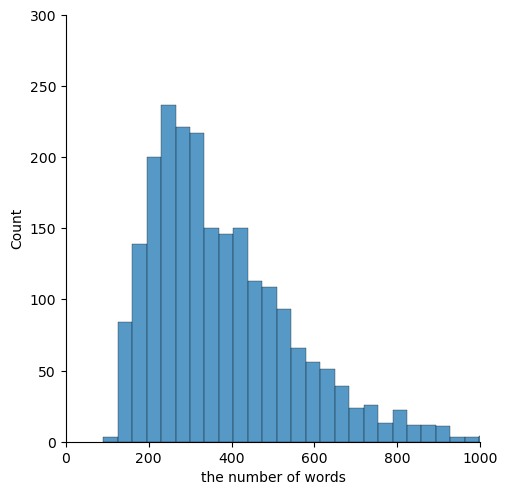

In [14]:
plt.figure(figsize=(8, 8))
sns.displot(df['count'])
plt.xlim(0, 1000)
plt.ylim(0, 300)
plt.xlabel('the number of words')
plt.show()

# Bar Plot for each of the new category

In [15]:
category_count = df['category'].value_counts()
categories = category_count.index
categories

Index(['sport', 'business', 'politics', 'tech', 'entertainment'], dtype='object', name='category')

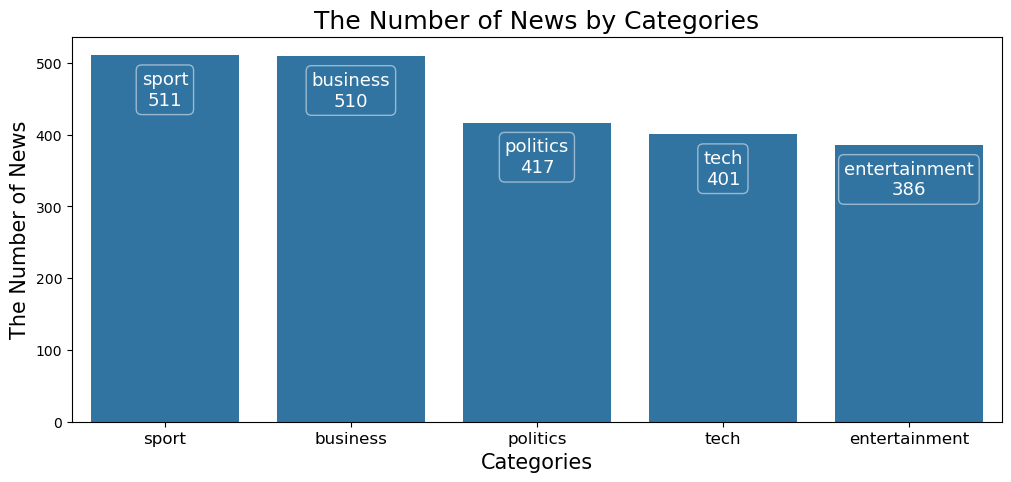

In [16]:

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Ensure `category_count` is a Pandas Series with proper indices
sns.barplot(x=category_count.index, y=category_count, ax=ax)

# Add annotations
for a, p in enumerate(ax.patches):
    ax.annotate(
        f'{category_count.index[a]}\n' + format(p.get_height(), '.0f'),
        xy=(p.get_x() + p.get_width() / 2.0, p.get_height()),
        xytext=(0, -25),
        size=13,
        color='white',
        ha='center',
        va='center',
        textcoords='offset points',
        bbox=dict(boxstyle='round', facecolor='none', edgecolor='white', alpha=0.5)
    )

plt.xlabel('Categories', size=15)
plt.ylabel('The Number of News', size=15)
plt.xticks(size=12)
plt.title("The Number of News by Categories", size=18)
plt.show()


In [17]:
df['encoded_text'] = df['category'].astype('category').cat.codes
df.head(5)

,category,text,count,encoded_text
0,tech,tv future in the hands of viewers with home th...,737,4
1,business,worldcom boss left books alone former worldc...,300,0
2,sport,tigers wary of farrell gamble leicester say ...,246,3
3,sport,yeading face newcastle in fa cup premiership s...,341,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,1


In [18]:
data_texts = df['text'].to_list()
data_labels = df['encoded_text'].to_list()

# train test split

In [20]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)

# Model Definition

In [25]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# finetune with the TFTrainer class

In [28]:
from transformers import Trainer, TFTrainingArguments

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

In [ ]:
training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=7,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100                   
)

with training_args.strategy.scope():
    trainer_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

trainer = Trainer(
    model = trainer_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [ ]:
trainer.train()

In [ ]:

trainer.evaluate()

# saving model

In [ ]:

save_directory = "/saved_models" 

model.save_pretrained(save_directory)

toknizer.save_pretrained(save_directory)

# loading pretrained model

In [ ]:
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)

model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

In [ ]:

test_text = test_texts[0]

test_text

In [ ]:
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation=True,
    padding=True,
    return_tensors='tf'
)

output = model_fine_tuned(predict_input)[0]
prediction_value = tf.argmax(output, axis=1).numpy()[0]

prediction_value

# inferencing with pytorch

In [ ]:
import torch

from transformers import DistilBertForSequenceClassification

tokenizer_fine_tuned_pt = DistilBertTokenizer.from_pretrained(save_directory)


model_fine_tuned_pt = DistilBertForSequenceClassification.from_pretrained(save_directory, from_tf = True )

In [ ]:
predict_input_pt = tokenizer_fine_tuned_pt(test_text, truncation = True, padding = True, return_tensors = 'pt' )

ouput_pt = model_fine_tuned_pt(predict_input_pt)

prediction_value_pt = torch.argmax(ouput_pt[0], dim = 1 ).item()

prediction_value_pt